In [ ]:
# pip install python-mnist will install the required package
from mnist import MNIST
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from threading import Thread
from operator import itemgetter
from sklearn.ensemble import RandomForestClassifier
import torch
import torchvision                                 # datasets and transformations modules
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn                              # neural network module
import torch.nn.functional as F
import torch.optim as optim                        # optimization module
import torch.optim.lr_scheduler as lr_scheduler

In [ ]:
# All networks derive from the base class nn.Module
class Perceptron(nn.Module):
    # get input and output dimensions as input
    def __init__(self, d, K):
        # all derived classes must call __init__ method of super class
        super(Perceptron, self).__init__()
        # create a fully connected layer from input to output
        self.model = nn.Linear(d, K)
    
    # forward method should get the input and return the output
    def forward(self,x):
        batch_size = x.shape[0]
        # flatten the image from BxCxHXW to Bx784
        x = x.view(batch_size, -1)
        x = self.model(x.float())
        # softmax is internally done inside cross entropy loss
        return x

In [ ]:
class CustomGeneticForestClassifier:
    def __init__(self, N, generation_number, class_percentage):
        self.N = N
        self.generation_number = generation_number
        self.class_percentage = class_percentage
        self.trained_trees = []
        self.slp = None
        self.prediction_tree = None
        self.one_hot_encoder = None
        # torch parameters
        self.SEED = 0            # reproducability
        # NN Parameters
        self.EPOCHS = 20          # number of epochs
        self.LR = 0.01            # learning rate
        self.MOMENTUM = 0.9       # momentum for the optimizer
        self.WEIGHT_DECAY = 1e-5  # weight decay for the optimizer
        self.GAMMA = 0.1          # learning rate schedular
        self.BATCH_SIZE = 32      # number of images to load per iteration
        
        self.train_tree_batch = 20
        self.mutation_rate = 0.2
        self.population_list = None

    def train_net(self):
        # put the network in training mode
        self.slp.train()
        # keep record of the loss value
        epoch_loss = 0.0
        # use training data as batches
        for xt, rt in self.train_loader:
            # move training instances and corresponding labels into gpu if cuda is available
            xt, rt = xt.to(self.device), rt.to(self.device)
            # clear the previously accumulated gradients
            self.optimizer.zero_grad() 
            # forward the network
            yt = self.slp(xt)
            # calculate loss
            loss = self.loss_fn(yt, rt)
            # make a backward pass, calculate gradients
            loss.backward()
            # update weights
            self.optimizer.step()
            # accumulate loss
            epoch_loss += loss.item()
        return epoch_loss
        
    def train_tree(self, filter_label, state_counter, tree_list):
        
        y_train_subtree = self.y_train[self.y_train.label.isin(filter_label)]
        X_train_subtree = self.X_train.loc[y_train_subtree.index.values.tolist()]
        
        dtc = DecisionTreeClassifier(random_state=state_counter)
        dtc = dtc.fit(X_train_subtree,y_train_subtree)
        y_valid_filtered= self.y_valid[self.y_valid.label.isin(filter_label)]
        X_valid_filtered = self.X_valid.loc[y_valid_filtered.index]
        y_pred = dtc.predict(X_valid_filtered)
        tree_accuracy = metrics.accuracy_score(y_valid_filtered, y_pred)
        print(state_counter+1, end=" ")
        tree_list.append({"tree": dtc, "accuracy": tree_accuracy, "filter_label": filter_label})   
        
    def fit_trees(self, filter_labels, tree_list):
        print("Started to train {} trees.".format(len(filter_labels)))
        print("Trained Trees: ", end="")
        state_counter = 0
        train_threads = []
        for filter_label in filter_labels:
            train_threads.append(Thread(target=self.train_tree, args=[filter_label, state_counter, tree_list]))
            state_counter += 1
        for thread_index in range(0, len(train_threads), self.train_tree_batch ):
            current_train_threads = train_threads[thread_index:thread_index+self.train_tree_batch ]
            for train_thread in current_train_threads:
                train_thread.start()
            for train_thread in current_train_threads:
                train_thread.join()
        print("\n{} Trees are trained.".format(len(filter_labels)))
                
    def train_slp(self, one_hot_encoded_predictions):
        print("Started to train SLP.")
        self.d = one_hot_encoded_predictions.shape[1]      # number of input features 
        
        # print("SLP input dimension:", self.d)
        
        # manual seed to reproduce same resultsnet
        torch.manual_seed(self.SEED)
        # create the network
        self.slp = Perceptron(self.d,self.K)
        # check if CUDA is available
        cuda = torch.cuda.is_available()  
        self.device = torch.device("cuda:0" if cuda else "cpu")
        # if cuda is available move network into gpu
        self.slp.to(self.device)
        # specify the loss to be used
        # softmax is internally computed.
        self.loss_fn = nn.CrossEntropyLoss()
        # specify the optimizer to update the weights during backward pass
        self.optimizer = optim.SGD(self.slp.parameters(), lr=self.LR, momentum=self.MOMENTUM, weight_decay=self.WEIGHT_DECAY)
        # change learning rate over time
        self.scheduler = lr_scheduler.StepLR(self.optimizer, step_size=10, gamma=self.GAMMA) #CHECK THIS
        
        train_target = torch.tensor(self.y_train.values.flatten().astype(np.int32)).long()

        train = torch.tensor(one_hot_encoded_predictions) 

        train_tensor = torch.utils.data.TensorDataset(train, train_target) 
        self.train_loader = torch.utils.data.DataLoader(dataset = train_tensor, batch_size = self.BATCH_SIZE, shuffle = True, num_workers=8)
        
        # train the network
        for epoch in range(1,self.EPOCHS+1):
            # train network for one epoch
            self.train_net()
        # print("SLP Weights:", self.slp.model.weight)
        print("SLP is trained.")
        
    def one_hot_encode(self, total_predictions):
        self.one_hot_encoder = OneHotEncoder(handle_unknown='ignore') 
        self.one_hot_encoder.fit(total_predictions)
        
        one_hot_encoded_predictions = self.one_hot_encoder.transform(total_predictions).toarray() 
        return one_hot_encoded_predictions

    
    def train_prediction_tree(self, one_hot_encoded_predictions):
        self.prediction_tree = DecisionTreeClassifier(random_state=200)
        self.prediction_tree = self.prediction_tree.fit(one_hot_encoded_predictions, self.y_train)
        
        
    def fit(self, X_train, y_train):
        self.X_train, self.X_valid, self.y_train, self.y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)  # Train-test split pairs
        self.label_count = len(y_train.label.unique())
        self.sample_count = y_train.shape[0]
        self.K = self.label_count              # number of output features
        
        self.population_list = self.genetic_find_parameters()
        last_population = self.population_list[-1]
        
        self.trained_trees = [member['tree'] for member in last_population]
        
        total_predictions = self.forest_trees_predict(self.X_train)
        one_hot_encoded_predictions = self.one_hot_encode(total_predictions)
        self.train_slp(one_hot_encoded_predictions)
        self.train_prediction_tree(total_predictions)
        
    def model_analysis(self, X_train, y_train, X_test, y_test):
        self.X_train, self.X_valid, self.y_train, self.y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)  # Train-test split pairs
        self.label_count = len(y_train.label.unique())
        self.sample_count = y_train.shape[0]
        self.K = self.label_count              # number of output features
        
        self.population_list = self.genetic_find_parameters()
        
        majority_accuracies = []
        slp_accuracies = []
        prediction_tree_accuracies = []
        population_mean_accuracies = []
        
        for population in self.population_list:
            
            population_mean_accuracy = np.mean(np.asarray([member['accuracy'] for member in population]))
            population_mean_accuracies.append(population_mean_accuracy)

            self.trained_trees = [member['tree'] for member in population]
            total_predictions = self.forest_trees_predict(self.X_train)
            one_hot_encoded_predictions = self.one_hot_encode(total_predictions)
            self.train_slp(one_hot_encoded_predictions)
            self.train_prediction_tree(total_predictions)
            
            majority_voting_pred = self.majority_voting_predict(X_test)
            slp_pred = self.slp_predict(X_test)
            prediction_tree_predict = self.prediction_tree_predict(X_test)
            
            majority_accuracy = metrics.accuracy_score(y_test, majority_voting_pred)
            slp_accuracy = metrics.accuracy_score(y_test, slp_pred)
            prediction_tree_accuracy = metrics.accuracy_score(y_test, prediction_tree_predict)
            
            majority_accuracies.append(majority_accuracy)
            slp_accuracies.append(slp_accuracy)
            prediction_tree_accuracies.append(prediction_tree_accuracy)
        generation_numbers = np.arange(len(self.population_list))
        return generation_numbers, prediction_tree_accuracies, slp_accuracies, majority_accuracies, population_mean_accuracies
        
    
    def majority_voting_predict(self, X_test):
        total_predictions = self.forest_trees_predict(X_test)
        # Majority Voting
        predicted_values = []
        for row in total_predictions:
            majority_vote = np.bincount(row).argmax()
            predicted_values.append(majority_vote)
        y_pred_class = np.asarray(predicted_values)
        return y_pred_class
    
    def slp_predict(self, X_test):
        total_predictions = self.forest_trees_predict(X_test)
        # SLP
        one_hot_encoded_predictions = self.one_hot_encoder.transform(total_predictions).toarray() 
        test = torch.tensor(one_hot_encoded_predictions) 
        y_pred = self.slp(test.to(self.device))
        y_pred = y_pred.cpu().detach().numpy()
        y_pred_class = np.asarray([np.argmax(pred) for pred in y_pred])
        return y_pred_class
    
    def prediction_tree_predict(self, X_test):
        total_predictions = self.forest_trees_predict(X_test)
        # Prediction Tree
        y_pred_class = self.prediction_tree.predict(total_predictions)
        return y_pred_class
    
    def forest_trees_predict(self, X_test):
        total_predictions = self.trained_trees[0].predict(X_test)
        for i in range(1, self.N):
            total_predictions = np.vstack([total_predictions, self.trained_trees[i].predict(X_test)])
        total_predictions = np.transpose(total_predictions)
        return total_predictions
    
    
    # Genetic algorithm  
    def generate_parent_samples(self):
        generation = []
        for i in range(self.N):
            generation.append(np.random.choice(range(self.label_count), round(self.label_count*self.class_percentage), replace=False))
        return generation  


    def genetic_find_parameters(self):
        print("Genetic algorithm is started.")
        generation = self.generate_parent_samples()
        population_list = []
        for i in range(self.generation_number+1):
            print("Generation:",i)
            trained_tree_results = []
            self.fit_trees(generation, trained_tree_results)
            population_list.append(trained_tree_results)
            generation = self.evolve(trained_tree_results)
        print("\nGenetic algorithm is ended.")
        return population_list
    
        
    def evolve(self, trained_tree_results):
        
        trained_tree_results_sorted = sorted(trained_tree_results, key=itemgetter("accuracy"), reverse=True)
        
        next_generation = []
        
        # Elitism
        next_generation.append(trained_tree_results_sorted[0]["filter_label"])
        for i in range(1, len(trained_tree_results)):
            parent_1 = self.tournament(trained_tree_results)
            parent_2 = self.tournament(trained_tree_results)
            child = self.crossover(parent_1, parent_2)
            child = self.mutate(child)  
            next_generation.append(child)        
        return next_generation

    
    def crossover(self, parent1, parent2):
        parents_merged = np.unique(np.append(parent1, parent2))
        child = np.random.choice(parents_merged, len(parent1), replace=False)
        return np.sort(child)

    
    def mutate(self, child):
        mutated_child = []
        if len(child) == self.label_count:
            return child
        non_existing_labels = []
        for label in range(self.label_count):
            if label not in child:
                non_existing_labels.append(label)
        for gen in child:
            if np.random.random() < self.mutation_rate:
                selected_label_index = np.random.randint(len(non_existing_labels))
                mutated_child.append(non_existing_labels.pop(selected_label_index))
            else:
                mutated_child.append(gen)
        return np.sort(mutated_child)

    def tournament(self, generation):
        # print("*********** Tournament ***********")
        accuracies = np.asarray([tree["accuracy"] for tree in generation])
        accuracies -= np.min(accuracies)
        probabilities = np.asarray(accuracies)/sum(accuracies)
        # print("Probabilities:",probabilities)
        selected = np.random.choice(generation, 1, p=probabilities)[0]["filter_label"]
        # print("Selected:", selected)
        return selected

In [ ]:
np.random.seed(60) # reproducability

def mnist_dataset_read(path):
    mndata = MNIST(path)

    # read training images and corresponding labels
    tr_images, tr_labels = mndata.load_training()
    # read test images and corresponding labels
    tt_images, tt_labels = mndata.load_testing()

    # convert lists into numpy format and apply normalization
    tr_images = np.array(tr_images) / 255. # shape (60000, 784)
    tr_labels = np.array(tr_labels)         # shape (60000,)
    tt_images = np.array(tt_images) / 255. # shape (10000, 784)
    tt_labels = np.array(tt_labels)         # shape (10000,)

    columns_images = ['p{}'.format(i+1) for i in range(784)]
    X_train = pd.DataFrame(data=tr_images, columns=columns_images)
    y_train = pd.DataFrame(data=tr_labels, columns=['label'])
    X_test = pd.DataFrame(data=tt_images, columns=columns_images)
    y_test = pd.DataFrame(data=tt_labels, columns=['label'])
    return X_train, X_test, y_train, y_test

In [ ]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_data(btch):
    labels = btch[b'labels']
    imgs = btch[b'data'].reshape((-1, 32, 32, 3))
    
    res = []
    for ii in range(imgs.shape[0]):
        img = imgs[ii].copy()
        #img = np.transpose(img.flatten().reshape(3,32,32))
        img = np.fliplr(np.rot90(np.transpose(img.flatten().reshape(3,32,32)), k=-1))
        res.append(img)
    imgs = np.stack(res)
    return labels, imgs

def load_data_cifar():
    batch1 = unpickle("Datasets/cifar-10-batches-py/data_batch_1")
    batch2 = unpickle("Datasets/cifar-10-batches-py/data_batch_2")
    batch3 = unpickle("Datasets/cifar-10-batches-py/data_batch_3")
    batch4 = unpickle("Datasets/cifar-10-batches-py/data_batch_4")
    batch5 = unpickle("Datasets/cifar-10-batches-py/data_batch_5")
    test_batch = unpickle("Datasets/cifar-10-batches-py/test_batch")
    
    pixel_num = 32*32*3
    x_train_l = []
    y_train_l = []
    for ibatch in [batch1, batch2, batch3, batch4, batch5]:
        labels, imgs = load_data(ibatch)
        x_train_l.append(imgs)
        y_train_l.extend(labels)
    x_train = np.vstack(x_train_l)
    y_train = np.vstack(y_train_l)
    
    x_test_l = []
    y_test_l = []
    labels, imgs = load_data(test_batch)
    x_test_l.append(imgs)
    y_test_l.extend(labels)
    x_test = np.vstack(x_test_l)
    y_test = np.vstack(y_test_l)
    
    del batch1, batch2, batch3, batch4, batch5, test_batch
    
    # imgplot = plt.imshow(x_train[58])
    
    x_train, x_test = x_train.reshape(-1, pixel_num), x_test.reshape(-1, pixel_num)
    
    columns_images = ['p{}'.format(i+1) for i in range(pixel_num)]
    X_train = pd.DataFrame(data=x_train, columns=columns_images)
    y_train = pd.DataFrame(data=y_train, columns=['label'])
    X_test = pd.DataFrame(data=x_test, columns=columns_images)
    y_test = pd.DataFrame(data=y_test, columns=['label'])
    
    return X_train, y_train, X_test, y_test

In [ ]:
def plot_genetic_analysis(generation_numbers, prediction_tree_accuracies, slp_accuracies, majority_accuracies, population_mean_accuracies, dataset_name):
    plt.figure(figsize=(20, 10))
    plt.plot(generation_numbers, prediction_tree_accuracies, marker="o", label = "Prediction Tree")
    plt.plot(generation_numbers, slp_accuracies, marker="o", label = "SLP")
    plt.plot(generation_numbers, majority_accuracies, marker="o", label = "Majority Voting")
    plt.plot(generation_numbers, population_mean_accuracies, marker="o", label = "Population Mean*")
    plt.title("Accuracies of Generations ({} Dataset)\n".format(dataset_name), fontsize=25)
    plt.xlabel("\nGeneration Number\n\n * Population mean accuracy is calculated for each tree only by using data from their train labels.", fontsize=15)
    plt.ylabel("Accuracy\n", fontsize=20)
    plt.legend(loc='lower right', prop={'size': 15})
    plt.show()

In [ ]:
m_X_train, m_X_test, m_y_train, m_y_test = mnist_dataset_read('Datasets/MNIST')
fm_X_train, fm_X_test, fm_y_train, fm_y_test = mnist_dataset_read('Datasets/Fashion_MNIST')
c_X_train, c_y_train, c_X_test, c_y_test = load_data_cifar()

In [8]:
# cgfc = CustomGeneticForestClassifier(N=200, generation_number=10, class_percentage = 0.5)

In [9]:
# m_generation_numbers, m_prediction_tree_accuracies, m_slp_accuracies, m_majority_accuracies, m_population_mean_accuracies = cgfc.model_analysis(m_X_train, m_y_train, m_X_test, m_y_test)

Genetic algorithm is started.
Generation: 0
Started to train 200 trees.
Trained Trees: 19 1 15 16 17 7 8 9 20 3 11 4 2 5 13 14 10 18 6 12 33 29 22 21 30 26 34 40 25 37 32 36 38 24 28 27 31 23 35 39 47 52 41 56 5960  48 44 51 55 54 43 49 46 50 42 53 58 57 45 61 78 69 66 68 74 73 65 62 77 67 71 70 72 64 75 79 63 76 80 83 94 98 95 90 86 97 89 93 81 84 82 87 99 85 88 92 91 100 96 105 114 102 104 110 113 118 109 120 117 106 112 116 108 101 103 107 111 115 119 134 133 137 130 126 125 127 124 121 138 129 123 122 132 131 136 135 139 128 140 160 147 142 156 155 159 152 151 158 144 143 141 153 146 150 148 157 145 154 149 176 163 180 177 165 168 175 162 167 174 164 166 179 173 169 161 172 170 171 178 190 189 193 182 198 194 197 181 188 184 196 186 185 183 192 195 191 200 187 199 
200 Trees are trained.
Generation: 1
Started to train 200 trees.
Trained Trees: 4 5 2 17 9 14 13 18 10 8 3 6 15 7 20 12 1 19 16 11 40 28 27 36 32 35 39 31 30 34 38 23 24 22 25 21 33 26 29 37 47 42 54 44 46 45 58 50 49 41

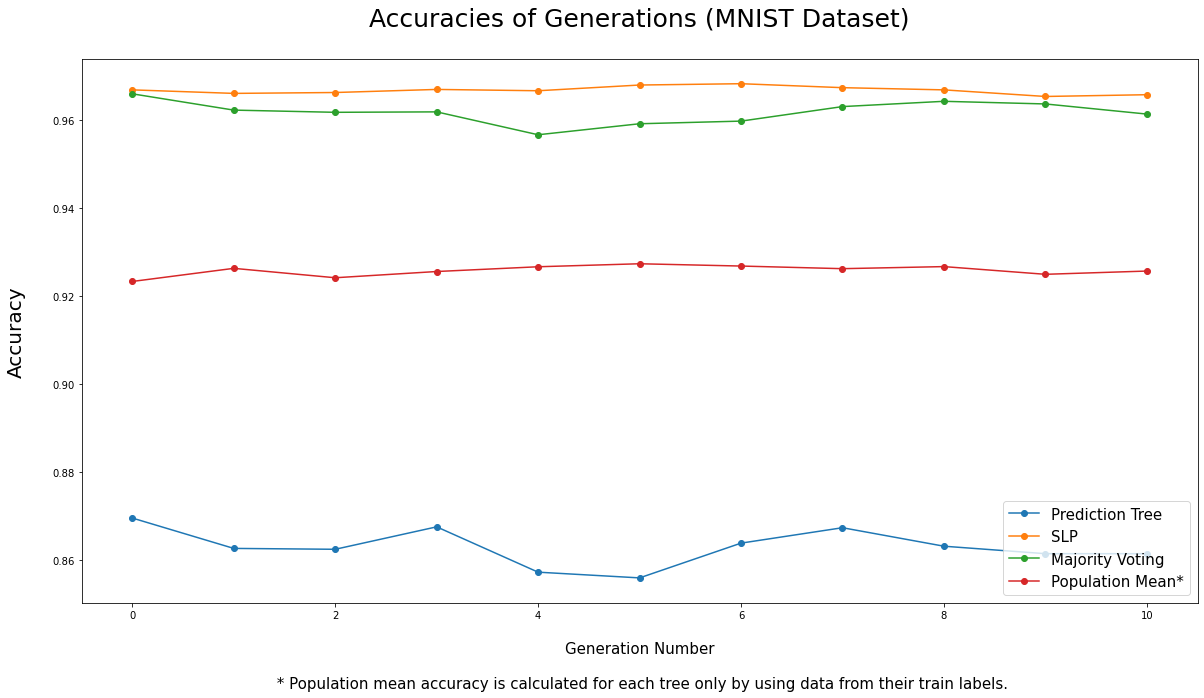

In [10]:
# plot_genetic_analysis(m_generation_numbers, m_prediction_tree_accuracies, m_slp_accuracies, m_majority_accuracies, m_population_mean_accuracies, dataset_name = "MNIST")

In [33]:
# for i in range(len(m_generation_numbers)):
#     print("Generation ", m_generation_numbers[i], ":", end=" ") 
#     print("\tSLP:{}\tMajority Voting:{}\tPrediction Tree:{}\tPopulation Mean Accuracy:{}".format(m_slp_accuracies[i], m_majority_accuracies[i], m_prediction_tree_accuracies[i], m_population_mean_accuracies[i]))

Generation  0 : 	SLP:0.9669	Majority Voting:0.966	Prediction Tree:0.8696	Population Mean Accuracy:0.9233618247754117
Generation  1 : 	SLP:0.9661	Majority Voting:0.9623	Prediction Tree:0.8627	Population Mean Accuracy:0.9263423929021506
Generation  2 : 	SLP:0.9663	Majority Voting:0.9618	Prediction Tree:0.8625	Population Mean Accuracy:0.924204976879487
Generation  3 : 	SLP:0.967	Majority Voting:0.9619	Prediction Tree:0.8676	Population Mean Accuracy:0.9256209642802525
Generation  4 : 	SLP:0.9667	Majority Voting:0.9567	Prediction Tree:0.8573	Population Mean Accuracy:0.9267027510898509
Generation  5 : 	SLP:0.968	Majority Voting:0.9592	Prediction Tree:0.856	Population Mean Accuracy:0.9273847879685274
Generation  6 : 	SLP:0.9683	Majority Voting:0.9598	Prediction Tree:0.8639	Population Mean Accuracy:0.9268635148685288
Generation  7 : 	SLP:0.9674	Majority Voting:0.9631	Prediction Tree:0.8674	Population Mean Accuracy:0.9262677885986479
Generation  8 : 	SLP:0.9669	Majority Voting:0.9643	Prediction

In [11]:
# cgfc = CustomGeneticForestClassifier(N=200, generation_number=10, class_percentage = 0.5)

In [12]:
# fm_generation_numbers, fm_prediction_tree_accuracies, fm_slp_accuracies, fm_majority_accuracies, fm_population_mean_accuracies = cgfc.model_analysis(fm_X_train, fm_y_train, fm_X_test, fm_y_test)

Genetic algorithm is started.
Generation: 0
Started to train 200 trees.
Trained Trees: 7 2 19 4 1 6 8 12 20 9 11 17 10 13 18 15 14 3 5 16 25 21 30 34 38 37 33 22 29 39 23 28 31 24 35 26 27 36 40 32 57 45 46 42 50 49 53 54 58 60 44 47 51 52 56 41 55 48 59 43 73 69 78 77 64 68 62 65 70 61 74 79 66 67 72 80 71 76 63 75 93 89 82 94 85 97 90 95 86 83 96 100 92 81 99 98 87 84 88 91 102 106 105 103 113 117 110 114 112 118 107 116 101 109 104 111 115 120 108 119 121 138 133 126 137 130 134 129 128 125 140 136 122 123 124 132 127 135 131 139 153 157 154 146 149 145 156 158 150 143 141 151 159 148 155 142 160 147 152 144 169 164 168 178 174 177 161 170 173 166 162 180 171 165 176 163 175 167 179 172 184 195 192 191 188 200 199 190 196 187 193 182 186 181 189 183 194 198 197 185 
200 Trees are trained.
Generation: 1
Started to train 200 trees.
Trained Trees: 17 3 1 5 16 8 2 13 19 9 6 18 20 4 7 14 10 12 15 11 33 30 26 29 36 23 21 38 31 24 28 25 34 37 39 35 32 40 22 27 60 49 48 51 55 52 44 59 42 43

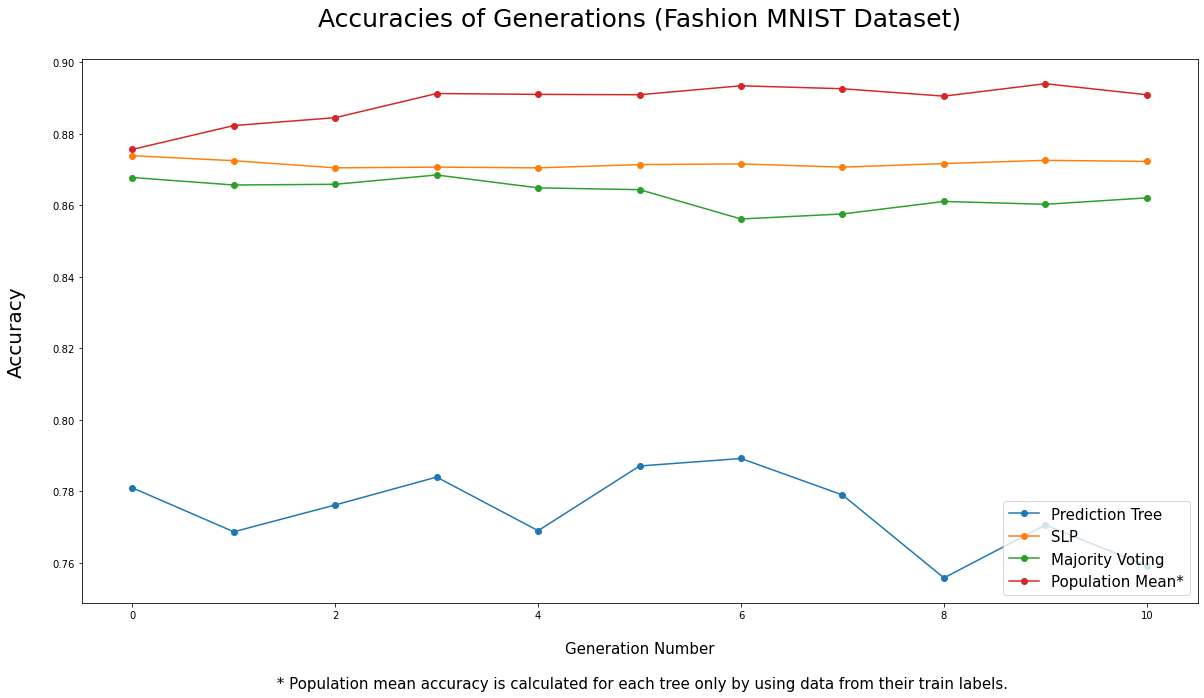

In [13]:
# plot_genetic_analysis(fm_generation_numbers, fm_prediction_tree_accuracies, fm_slp_accuracies, fm_majority_accuracies, fm_population_mean_accuracies, dataset_name = "Fashion MNIST")

In [34]:
# for i in range(len(fm_generation_numbers)):
#     print("Generation ", fm_generation_numbers[i], ":", end=" ") 
#     print("\tSLP:{}\tMajority Voting:{}\tPrediction Tree:{}\tPopulation Mean Accuracy:{}".format(fm_slp_accuracies[i], fm_majority_accuracies[i], fm_prediction_tree_accuracies[i], fm_population_mean_accuracies[i]))

Generation  0 : 	SLP:0.8738	Majority Voting:0.8677	Prediction Tree:0.7809	Population Mean Accuracy:0.8755487770887777
Generation  1 : 	SLP:0.8724	Majority Voting:0.8656	Prediction Tree:0.7686	Population Mean Accuracy:0.8822277614296021
Generation  2 : 	SLP:0.8704	Majority Voting:0.8658	Prediction Tree:0.7761	Population Mean Accuracy:0.8844360187678171
Generation  3 : 	SLP:0.8706	Majority Voting:0.8684	Prediction Tree:0.7839	Population Mean Accuracy:0.8911910589453188
Generation  4 : 	SLP:0.8704	Majority Voting:0.8648	Prediction Tree:0.7689	Population Mean Accuracy:0.8909562806735153
Generation  5 : 	SLP:0.8713	Majority Voting:0.8643	Prediction Tree:0.787	Population Mean Accuracy:0.8908504351026575
Generation  6 : 	SLP:0.8715	Majority Voting:0.8561	Prediction Tree:0.7891	Population Mean Accuracy:0.8933557984764675
Generation  7 : 	SLP:0.8706	Majority Voting:0.8575	Prediction Tree:0.7789	Population Mean Accuracy:0.8925298305815619
Generation  8 : 	SLP:0.8716	Majority Voting:0.861	Predict

In [ ]:
cgfc = CustomGeneticForestClassifier(N=200, generation_number=10, class_percentage = 0.5)

In [ ]:
c_generation_numbers, c_prediction_tree_accuracies, c_slp_accuracies, c_majority_accuracies, c_population_mean_accuracies = cgfc.model_analysis(c_X_train, c_y_train, c_X_test, c_y_test)

In [ ]:
plot_genetic_analysis(c_generation_numbers, c_prediction_tree_accuracies, c_slp_accuracies, c_majority_accuracies, c_population_mean_accuracies, dataset_name = "Cifar-10")

In [ ]:
for i in range(len(c_generation_numbers)):
    print("Generation ", c_generation_numbers[i], ":", end=" ") 
    print("\tSLP:{}\tMajority Voting:{}\tPrediction Tree:{}\tPopulation Mean Accuracy:{}".format(c_slp_accuracies[i], c_majority_accuracies[i], c_prediction_tree_accuracies[i], c_population_mean_accuracies[i]))

In [ ]:
def plot_accuracies(x_values, accuracies, title, x_label):
    plt.figure(figsize=(20, 10))
    for algorithm, accuracies in accuracies.items():
        plt.plot(x_values, accuracies, marker="o", label = algorithm)
    plt.title(title, fontsize=25)
    plt.xlabel("\n{}".format(x_label), fontsize=15)
    plt.ylabel("Accuracy\n", fontsize=20)
    plt.legend(loc='lower right', prop={'size': 15})
    plt.show()

In [ ]:
def get_accuracies(X_train, X_test, y_train, y_test, tree_number, generation_number, class_percentage):
    cgfc = CustomGeneticForestClassifier(N=tree_number, generation_number = generation_number, class_percentage = class_percentage)
    cgfc.fit(X_train, y_train)
    slp_pred=cgfc.slp_predict(X_test)
    prediction_tree_pred=cgfc.prediction_tree_predict(X_test)
    majority_voting_pred=cgfc.majority_voting_predict(X_test)
    
    slp_accuracy = metrics.accuracy_score(y_test, slp_pred)
    prediction_tree_accuracy = metrics.accuracy_score(y_test, prediction_tree_pred)
    majority_voting_accuracy = metrics.accuracy_score(y_test, majority_voting_pred)
    
    return slp_accuracy, majority_voting_accuracy, prediction_tree_accuracy

In [ ]:
def number_of_trees_analysis(N_list, X_train, X_test, y_train, y_test):
    accuracies_of_N_trees_y = {"SLP": [], "Prediction Tree": [], "Majority Voting": [], "Random Forest (scikit-learn)":[]}
    for N in N_list:
        slp_accuracy, majority_voting_accuracy, prediction_tree_accuracy = get_accuracies(X_train, X_test, y_train, y_test, tree_number = N, generation_number = 5, class_percentage = 0.5)
        rf = RandomForestClassifier(n_estimators = N, max_samples = 0.5)
        X_train_rf, X_valid_rf, y_train_rf, y_valid_rf = train_test_split(X_train, y_train, test_size=0.2, random_state=0) 
        rf.fit(X_train_rf, y_train_rf.values.ravel())
        rf_pred = rf.predict(X_test)
        accuracies_of_N_trees_y["Random Forest (scikit-learn)"].append(metrics.accuracy_score(y_test, rf_pred))
        accuracies_of_N_trees_y["SLP"].append(slp_accuracy)
        accuracies_of_N_trees_y["Prediction Tree"].append(prediction_tree_accuracy)
        accuracies_of_N_trees_y["Majority Voting"].append(majority_voting_accuracy)
    return accuracies_of_N_trees_y

In [ ]:
def class_percentage_analysis(class_percentage_list, X_train, X_test, y_train, y_test):
    accuracies_of_class_percentages_y = {"SLP": [], "Prediction Tree": [], "Majority Voting": []}
    for class_percentage in class_percentage_list:
        slp_accuracy, majority_voting_accuracy, prediction_tree_accuracy = get_accuracies(X_train, X_test, y_train, y_test, tree_number = 100, generation_number = 5, class_percentage = class_percentage)
        accuracies_of_class_percentages_y["SLP"].append(slp_accuracy)
        accuracies_of_class_percentages_y["Prediction Tree"].append(prediction_tree_accuracy)
        accuracies_of_class_percentages_y["Majority Voting"].append(majority_voting_accuracy)
    return accuracies_of_class_percentages_y

In [ ]:
N_list = [i*25 for i in range(1,13)]

In [ ]:
m_accuracies_of_N_trees_y = number_of_trees_analysis(N_list, m_X_train, m_X_test, m_y_train, m_y_test)

In [ ]:
plot_title = "Accuracy of Algorithms wrt. Number of Trees (MNIST)\n"
plot_accuracies(N_list, m_accuracies_of_N_trees_y, plot_title, "N Trees")
print(m_accuracies_of_N_trees_y)

In [ ]:
fm_accuracies_of_N_trees_y = number_of_trees_analysis(N_list, fm_X_train, fm_X_test, fm_y_train, fm_y_test)

In [ ]:
plot_title = "Accuracy of Algorithms wrt. Number of Trees (Fashion MNIST)\n"
plot_accuracies(N_list, fm_accuracies_of_N_trees_y, plot_title, "N Trees")
print(fm_accuracies_of_N_trees_y)

In [ ]:
c_accuracies_of_N_trees_y = number_of_trees_analysis(N_list, c_X_train, c_X_test, c_y_train, c_y_test)

In [ ]:
plot_title = "Accuracy of Algorithms wrt. Number of Trees (Cifar-10)\n"
plot_accuracies(N_list, c_accuracies_of_N_trees_y, plot_title, "N Trees")
print(c_accuracies_of_N_trees_y)

In [ ]:
class_percentage_list = [i*0.2 for i in range(1,6)]

In [ ]:
m_accuracies_of_class_percentages_y = class_percentage_analysis(class_percentage_list, m_X_train, m_X_test, m_y_train, m_y_test)

In [ ]:
plot_title = "Accuracy of Algorithms wrt. Class Percentage (MNIST)\n"
plot_accuracies(class_percentage_list, m_accuracies_of_class_percentages_y, plot_title, "Class Percentage")
print(m_accuracies_of_class_percentages_y)

In [ ]:
fm_accuracies_of_class_percentages_y = class_percentage_analysis(class_percentage_list, fm_X_train, fm_X_test, fm_y_train, fm_y_test)

In [ ]:
plot_title = "Accuracy of Algorithms wrt. Class Percentage (Fashion MNIST)\n"
plot_accuracies(class_percentage_list, fm_accuracies_of_class_percentages_y, plot_title, "Class Percentage")
print(fm_accuracies_of_class_percentages_y)

In [ ]:
c_accuracies_of_class_percentages_y = class_percentage_analysis(class_percentage_list, c_X_train, c_X_test, c_y_train, c_y_test)

In [ ]:
plot_title = "Accuracy of Algorithms wrt. Class Percentage (Cifar-10)\n"
plot_accuracies(class_percentage_list, c_accuracies_of_class_percentages_y, plot_title, "Class Percentage")
print(c_accuracies_of_class_percentages_y)